In [ ]:
#all the imports
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import norm
from scipy.stats import shapiro
import pandas as pd

Load MNIST data and define the networks

In [ ]:
!git clone https://github.com/SimonGodskesen/NetworkProject

Cloning into 'NetworkProject'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 252 (delta 0), reused 0 (delta 0), pack-reused 232
Receiving objects: 100% (252/252), 114.44 MiB | 29.00 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
#Load and transform MNIST data, divide into train and test set, and create an iterator
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 5
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=False)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



The following code investigastes realation between node strength distribution, absolute node strength distribution, number of layers, choice of optimizer, and accuracy. This part is written by Lovisa Eriksson

In [ ]:
# Class for dense 2-layer networks with sigmoid as activation, 
# for mnist or other datasets with input of size 784 and 10 classes

class NetSigmoid2(nn.Module):  
    
    def __init__(self, layer1, layer2):
    #    layer1: number of nodes in the first hidden layer
    #    layer2: number of nodes in second hidden layer
        super().__init__()
        self.fc1 = nn.Linear(784, layer1)
        self.fc2 = nn.Linear(layer1, layer2)
        self.fc3 = nn.Linear(layer2, 10)        
        
    def forward(self, x):
    #   x: input data
    #   return: output of network
        x = torch.flatten(x, 1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

Functions to calculate:

*   Node strength in first hidden layer
*   Node strength in second hidden layer
*   Absolute node strength in first hidden layer
*   Absolute node strength in second hidden layer
*   Accuracy

In [ ]:
#function to calculate node strength of nodes in first hidden layer
def NodeStrength1(net):
  # net: net to calculate node strength of
    weight_layer1 = net.fc1.weight.data
    weight_layer2 = net.fc2.weight.data
    bias_layer1 = net.fc1.bias.data

    node_strength1 = np.zeros(weight_layer1.size(dim=0))
    for i in range(weight_layer1.size(dim=0)):
        node_strength1[i] += weight_layer1[i, :].sum()
        node_strength1[i] += bias_layer1[i]*weight_layer1.size(dim=1) 
        node_strength1[i] += weight_layer2[:, i].sum()
    return(node_strength1)

# function to calculate node strength of nodes in second hidden layer
def NodeStrength2(net):
  # net: net to calculate node strength of
    weight_layer2 = net.fc2.weight.data
    weight_layer3 = net.fc3.weight.data
    bias_layer2 = net.fc2.bias.data

    node_strength2 = np.zeros(weight_layer2.size(dim=0))
    for i in range(weight_layer2.size(dim=0)):
        node_strength2[i] += weight_layer2[i, :].sum()
        node_strength2[i] += bias_layer2[i]*weight_layer2.size(dim=1) 
        node_strength2[i] += weight_layer3[:, i].sum()
    return(node_strength2)


In [ ]:
#function to calculate absolute node strength of nodes in the first hidden layer
def AbsoluteNodeStrength1(net):
  # net: net to calculate node strength of
    weight_layer1 = net.fc1.weight.data
    weight_layer2 = net.fc2.weight.data
    bias_layer1 = net.fc1.bias.data

    absolute_node_strength1 = np.zeros(weight_layer1.size(dim=0))
    for i in range(weight_layer1.size(dim=0)):
        for j in range(weight_layer1.size(dim=1)):
            absolute_node_strength1[i] += abs(weight_layer1[i, j]+bias_layer1[i]) 
        for k in range(weight_layer2.size(dim=0)):
            absolute_node_strength1[i] += abs(weight_layer2[k, i])
    return(absolute_node_strength1)

#function to calculate absolute node strength of nodes in the second hidden layer
def AbsoluteNodeStrength2(net):
  # net: net to calculate node strength of
    weight_layer2 = net.fc2.weight.data
    weight_layer3 = net.fc3.weight.data
    bias_layer2 = net.fc2.bias.data

    absolute_node_strength2 = np.zeros(weight_layer2.size(dim=0))
    for i in range(weight_layer2.size(dim=0)):
        for j in range(weight_layer2.size(dim=1)):
            absolute_node_strength2[i] += abs(weight_layer2[i, j]+bias_layer2[i]) 
        for k in range(weight_layer3.size(dim=0)):
            absolute_node_strength2[i] += abs(weight_layer3[k, i])
    return(absolute_node_strength2)

In [ ]:
# Function for calculating accuracy of network
def Accuracy(net, testloader):
    # net: net to calculate accuracy of
    # testloader: loader for the test data
    
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(testloader,0):
            inputs, labels = data
            outputs = net(inputs)
            for i,e in enumerate(outputs):
                if torch.argmax(e) == labels[i]:
                    correct += 1
                total += 1

    return correct/total

In [ ]:
#function to calculate mean node strength and layers fluctuation, or mean absolute node strength and absolute fluctuation, depending on chosen type
def MeanAndFluct(netlist, layer, type="nodestrength"):
  # input
  # netlist: list of networks to calculate on
  # layer: the layer to calculate on. 1 or 2 allowed
  # type: "nodestrength" (default) gives mean node strength and layers fluctuation, and
  #       "absolute" gives mean absolute node strength and absolute layers fluctuation
  
    mean = []
    fluct = []
    
    if type == "nodestrength":

        if layer == 1:
            for net in netlist:
                nodestrength = NodeStrength1(net)
                mean.append(nodestrength.mean())
                fluct.append(nodestrength.std())
        elif layer == 2:
            for net in netlist:
                nodestrength = NodeStrength2(net)
                mean.append(nodestrength.mean())
                fluct.append(nodestrength.std())
        else:
            raise Exception('Layer must be 1 or 2')
            
    elif type == "absolute":
        if layer == 1:
            for net in netlist:
                nodestrength = AbsoluteNodeStrength1(net)
                mean.append(nodestrength.mean())
                fluct.append(nodestrength.std())
        elif layer == 2:
            for net in netlist:
                nodestrength = AbsoluteNodeStrength2(net)
                mean.append(nodestrength.mean())
                fluct.append(nodestrength.std())
        else:
            raise Exception('Layer must be 1 or 2')
            
    else:
        raise Exception('type must be "nodestrength" or "absolute"')
        
    return mean, fluct

Load the pre-trained networks (change path as needed)

In [ ]:
# Load untrained networks 

# load 2+100 untrained networks
list2_100_untrained = []
for k in range(10):
    list2_100_untrained.append(NetSigmoid2(2, 100))
    list2_100_untrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\Untrained2_100_number{k}'))
    list2_100_untrained[i].eval()

# load 10+100 untrained networks
list10_100_untrained = []
for k in range(10):
    list10_100_untrained.append(NetSigmoid2(10, 100))
    list10_100_untrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\Untrained10_100_number{k}'))
    list10_100_untrained[i].eval()

# load 100+100 untrained networks
list100_100_untrained = []
for k in range(10):
    list100_100_untrained.append(NetSigmoid2(100, 100))
    list100_100_untrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\Untrained100_100_number{k}'))
    list100_100_untrained[i].eval()

# load 1000+100 untrained networks
list1000_100_untrained = []
for k in range(10):
    list1000_100_untrained.append(NetSigmoid2(1000, 100))
    list1000_100_untrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\Untrained1000_100_number{k}'))
    list1000_100_untrained[i].eval()

# load 10000+100 untrained networks
list10000_100_untrained = []
for k in range(10):
    list10000_100_untrained.append(NetSigmoid2(10, 100))
    list10000_100_untrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\Untrained10000_100_number{k}'))
    list10000_100_untrained[i].eval()  

In [ ]:
# Load the SGD trained networks

# load 2+100 SGD trained networks
list2_100_SGDtrained = []
for k in range(10):
    list2_100_SGDtrained.append(NetSigmoid2(2, 100))
    list2_100_SGDtrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\SGDtrained2_100_number{k}'))
    list2_100_SGDtrained[i].eval()

# load 10+100 SGD trained networks
list10_100_SGDtrained = []
for k in range(10):
    list10_100_SGDtrained.append(NetSigmoid2(10, 100))
    list10_100_SGDtrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\SGDtrained10_100_number{k}'))
    list10_100_SGDtrained[i].eval()

# load 100+100 SGD trained networks
list100_100_SGDtrained = []
for k in range(10):
    list100_100_SGDtrained.append(NetSigmoid2(100, 100))
    list100_100_SGDtrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\SGDtrained100_100_number{k}'))
    list100_100_SGDtrained[i].eval()

# load 1000+100 SGD trained networks
list1000_100_SGDtrained = []
for k in range(10):
    list1000_100_SGDtrained.append(NetSigmoid2(1000, 100))
    list1000_100_SGDtrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\SGDtrained1000_100_number{k}'))
    list1000_100_SGDtrained[i].eval()

# load 10000+100 SGD trained networks
list10000_100_SGDtrained = []
for k in range(10):
    list10000_100_SGDtrained.append(NetSigmoid2(10, 100))
    list10000_100_SGDtrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\SGDtrained10000_100_number{k}'))
    list10000_100_SGDtrained[i].eval()  

In [ ]:
# Load the Adam trained networks

# load 2+100 Adam trained networks
list2_100_Adamtrained = []
for k in range(10):
    list2_100_Adamtrained.append(NetSigmoid2(2, 100))
    list2_100_Adamtrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\Adamtrained2_100_number{k}'))
    list2_100_Adamtrained[i].eval()

# load 10+100Adam trained networks
list10_100_Adamtrained = []
for k in range(10):
    list10_100_Adamtrained.append(NetSigmoid2(10, 100))
    list10_100_Adamtrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\Adamtrained10_100_number{k}'))
    list10_100_Adamtrained[i].eval()

# load 100+100 Adam trained networks
list100_100_Adamtrained = []
for k in range(10):
    list100_100_Adamtrained.append(NetSigmoid2(100, 100))
    list100_100_Adamtrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\Adamtrained100_100_number{k}'))
    list100_100_Adamtrained[i].eval()

# load 1000+100 Adam trained networks
list1000_100_Adamtrained = []
for k in range(10):
    list1000_100_Adamtrained.append(NetSigmoid2(1000, 100))
    list1000_100_Adamtrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\Adamtrained1000_100_number{k}'))
    list1000_100_Adamtrained[i].eval()

# load 10000+100 Adam trained networks
list10000_100_Adamtrained = []
for k in range(10):
    list10000_100_Adamtrained.append(NetSigmoid2(10, 100))
    list10000_100_Adamtrained[i].load_state_dict(torch.load(f'C:\\Users\\lovis\\OneDrive\\Dokument\\SavedNetworks\\Adamtrained10000_100_number{k}'))
    list10000_100_Adamtrained[i].eval()  

Calculate mean node strength, absolute node strength, layers fluctuation and absolute layers fluctuation of the different network types

In [ ]:
# untrained networks, layer 1, ordinary node strength
mean_nodestrength1_2_100_untrained, fluctuation1_2_100_untrained = MeanAndFluct(list2_100_untrained, layer=1)
mean_nodestrength1_10_100_untrained, fluctuation1_10_100_untrained = MeanAndFluct(list10_100_untrained, layer=1)
mean_nodestrength1_100_100_untrained, fluctuation1_100_100_untrained = MeanAndFluct(list100_100_untrained, layer=1)
mean_nodestrength1_1000_100_untrained, fluctuation1_1000_100_untrained = MeanAndFluct(list1000_100_untrained, layer=1)
mean_nodestrength1_10000_100_untrained, fluctuation1_10000_100_untrained = MeanAndFluct(list10000_100_untrained, layer=1)

# untrained networks, layer 1, absolute node strength
abs_mean_nodestrength1_2_100_untrained, abs_fluctuation1_2_100_untrained = MeanAndFluct(list2_100_untrained, 
                                                                                        layer=1, type = "absolute")
abs_mean_nodestrength1_10_100_untrained, abs_fluctuation1_10_100_untrained = MeanAndFluct(list10_100_untrained, 
                                                                                          layer=1, type="absolute")
abs_mean_nodestrength1_100_100_untrained, abs_fluctuation1_100_100_untrained = MeanAndFluct(list100_100_untrained, 
                                                                                            layer=1, type="absolute")
abs_mean_nodestrength1_1000_100_untrained, abs_fluctuation1_1000_100_untrained = MeanAndFluct(list1000_100_untrained, 
                                                                                              layer=1, type="absolute")
abs_mean_nodestrength1_10000_100_untrained, abs_fluctuation1_10000_100_untrained = MeanAndFluct(list10000_100_untrained, 
                                                                                                layer=1, type="absolute")

# untrained networks, layer 2, ordinary node strength
mean_nodestrength2_2_100_untrained, fluctuation2_2_100_untrained = MeanAndFluct(list2_100_untrained, layer=2)
mean_nodestrength2_10_100_untrained, fluctuation2_10_100_untrained = MeanAndFluct(list10_100_untrained, layer=2)
mean_nodestrength2_100_100_untrained, fluctuation2_100_100_untrained = MeanAndFluct(list100_100_untrained, layer=2)
mean_nodestrength2_1000_100_untrained, fluctuation2_1000_100_untrained = MeanAndFluct(list1000_100_untrained, layer=2)
mean_nodestrength2_10000_100_untrained, fluctuation2_10000_100_untrained = MeanAndFluct(list10000_100_untrained, layer=2)

# untrained networks, layer 2, absolute node strength
abs_mean_nodestrength2_2_100_untrained, abs_fluctuation2_2_100_untrained = MeanAndFluct(list2_100_untrained, 
                                                                                        layer=2, type = "absolute")
abs_mean_nodestrength2_10_100_untrained, abs_fluctuation2_10_100_untrained = MeanAndFluct(list10_100_untrained, 
                                                                                          layer=2, type="absolute")
abs_mean_nodestrength2_100_100_untrained, abs_fluctuation2_100_100_untrained = MeanAndFluct(list100_100_untrained, 
                                                                                            layer=2, type="absolute")
abs_mean_nodestrength2_1000_100_untrained, abs_fluctuation2_1000_100_untrained = MeanAndFluct(list1000_100_untrained, 
                                                                                              layer=2, type="absolute")
abs_mean_nodestrength2_10000_100_untrained, abs_fluctuation2_10000_100_untrained = MeanAndFluct(list10000_100_untrained, 
                                                                                                layer=2, type="absolute")

In [ ]:
# SGD trained networks, layer 1, ordinary node strength
mean_nodestrength1_2_100_SGDtrained, fluctuation1_2_100_SGDtrained = MeanAndFluct(list2_100_SGDtrained, layer=1)
mean_nodestrength1_10_100_SGDtrained, fluctuation1_10_100_SGDtrained = MeanAndFluct(list10_100_SGDtrained, layer=1)
mean_nodestrength1_100_100_SGDtrained, fluctuation1_100_100_SGDtrained = MeanAndFluct(list100_100_SGDtrained, layer=1)
mean_nodestrength1_1000_100_SGDtrained, fluctuation1_1000_100_SGDtrained = MeanAndFluct(list1000_100_SGDtrained, layer=1)
mean_nodestrength1_10000_100_SGDtrained, fluctuation1_10000_100_SGDtrained = MeanAndFluct(list10000_100_SGDtrained, layer=1)

# SGD trained networks, layer 1, absolute node strength
abs_mean_nodestrength1_2_100_SGDtrained, abs_fluctuation1_2_100_SGDtrained = MeanAndFluct(list2_100_SGDtrained, 
                                                                                        layer=1, type = "absolute")
abs_mean_nodestrength1_10_100_SGDtrained, abs_fluctuation1_10_100_SGDtrained = MeanAndFluct(list10_100_SGDtrained, 
                                                                                          layer=1, type="absolute")
abs_mean_nodestrength1_100_100_SGDtrained, abs_fluctuation1_100_100_SGDtrained = MeanAndFluct(list100_100_SGDtrained, 
                                                                                            layer=1, type="absolute")
abs_mean_nodestrength1_1000_100_SGDtrained, abs_fluctuation1_1000_100_SGDtrained = MeanAndFluct(list1000_100_SGDtrained, 
                                                                                              layer=1, type="absolute")
abs_mean_nodestrength1_10000_100_SGDtrained, abs_fluctuation1_10000_100_SGDtrained = MeanAndFluct(list10000_100_SGDtrained, 
                                                                                                layer=1, type="absolute")

# SGD trained networks, layer 2, ordinary node strength
mean_nodestrength2_2_100_SGDtrained, fluctuation2_2_100_SGDtrained = MeanAndFluct(list2_100_SGDtrained, layer=2)
mean_nodestrength2_10_100_SGDtrained, fluctuation2_10_100_SGDtrained = MeanAndFluct(list10_100_SGDtrained, layer=2)
mean_nodestrength2_100_100_SGDtrained, fluctuation2_100_100_SGDtrained = MeanAndFluct(list100_100_SGDtrained, layer=2)
mean_nodestrength2_1000_100_SGDtrained, fluctuation2_1000_100_SGDtrained = MeanAndFluct(list1000_100_SGDtrained, layer=2)
mean_nodestrength2_10000_100_SGDtrained, fluctuation2_10000_100_SGDtrained = MeanAndFluct(list10000_100_SGDtrained, layer=2)

# SGD trained networks, layer 2, absolute node strength
abs_mean_nodestrength2_2_100_SGDtrained, abs_fluctuation2_2_100_SGDtrained = MeanAndFluct(list2_100_SGDtrained, 
                                                                                        layer=2, type = "absolute")
abs_mean_nodestrength2_10_100_SGDtrained, abs_fluctuation2_10_100_SGDtrained = MeanAndFluct(list10_100_SGDtrained, 
                                                                                          layer=2, type="absolute")
abs_mean_nodestrength2_100_100_SGDtrained, abs_fluctuation2_100_100_SGDtrained = MeanAndFluct(list100_100_SGDtrained, 
                                                                                            layer=2, type="absolute")
abs_mean_nodestrength2_1000_100_SGDtrained, abs_fluctuation2_1000_100_SGDtrained = MeanAndFluct(list1000_100_SGDtrained, 
                                                                                              layer=2, type="absolute")
abs_mean_nodestrength2_10000_100_SGDtrained, abs_fluctuation2_10000_100_SGDtrained = MeanAndFluct(list10000_100_SGDtrained, 
                                                                                                layer=2, type="absolute")

In [ ]:
# Adam trained networks, layer 1, ordinary node strength
mean_nodestrength1_2_100_Adamtrained, fluctuation1_2_100_Adamtrained = MeanAndFluct(list2_100_Adamtrained, layer=1)
mean_nodestrength1_10_100_Adamtrained, fluctuation1_10_100_Adamtrained = MeanAndFluct(list10_100_Adamtrained, layer=1)
mean_nodestrength1_100_100_Adamtrained, fluctuation1_100_100_Adamtrained = MeanAndFluct(list100_100_Adamtrained, layer=1)
mean_nodestrength1_1000_100_Adamtrained, fluctuation1_1000_100_Adamtrained = MeanAndFluct(list1000_100_Adamtrained, layer=1)
mean_nodestrength1_10000_100_Adamtrained, fluctuation1_10000_100_Adamtrained = MeanAndFluct(list10000_100_Adamtrained, layer=1)

# Adam trained networks, layer 1, absolute node strength
abs_mean_nodestrength1_2_100_Adamtrained, abs_fluctuation1_2_100_Adamtrained = MeanAndFluct(list2_100_Adamtrained, 
                                                                                        layer=1, type = "absolute")
abs_mean_nodestrength1_10_100_Adamtrained, abs_fluctuation1_10_100_Adamtrained = MeanAndFluct(list10_100_Adamtrained, 
                                                                                          layer=1, type="absolute")
abs_mean_nodestrength1_100_100_Adamtrained, abs_fluctuation1_100_100_Adamtrained = MeanAndFluct(list100_100_Adamtrained, 
                                                                                            layer=1, type="absolute")
abs_mean_nodestrength1_1000_100_Adamtrained, abs_fluctuation1_1000_100_Adamtrained = MeanAndFluct(list1000_100_Adamtrained, 
                                                                                              layer=1, type="absolute")
abs_mean_nodestrength1_10000_100_Adamtrained, abs_fluctuation1_10000_100_Adamtrained = MeanAndFluct(list10000_100_Adamtrained, 
                                                                                                layer=1, type="absolute")

# Adam trained networks, layer 2, ordinary node strength
mean_nodestrength2_2_100_Adamtrained, fluctuation2_2_100_Adamtrained = MeanAndFluct(list2_100_Adamtrained, layer=2)
mean_nodestrength2_10_100_Adamtrained, fluctuation2_10_100_Adamtrained = MeanAndFluct(list10_100_Adamtrained, layer=2)
mean_nodestrength2_100_100_Adamtrained, fluctuation2_100_100_Adamtrained = MeanAndFluct(list100_100_Adamtrained, layer=2)
mean_nodestrength2_1000_100_Adamtrained, fluctuation2_1000_100_Adamtrained = MeanAndFluct(list1000_100_Adamtrained, layer=2)
mean_nodestrength2_10000_100_Adamtrained, fluctuation2_10000_100_Adamtrained = MeanAndFluct(list10000_100_Adamtrained, layer=2)

# Adam trained networks, layer 2, absolute node strength
abs_mean_nodestrength2_2_100_Adamtrained, abs_fluctuation2_2_100_Adamtrained = MeanAndFluct(list2_100_Adamtrained, 
                                                                                        layer=2, type = "absolute")
abs_mean_nodestrength2_10_100_Adamtrained, abs_fluctuation2_10_100_Adamtrained = MeanAndFluct(list10_100_Adamtrained, 
                                                                                          layer=2, type="absolute")
abs_mean_nodestrength2_100_100_Adamtrained, abs_fluctuation2_100_100_Adamtrained = MeanAndFluct(list100_100_Adamtrained, 
                                                                                            layer=2, type="absolute")
abs_mean_nodestrength2_1000_100_Adamtrained, abs_fluctuation2_1000_100_Adamtrained = MeanAndFluct(list1000_100_Adamtrained, 
                                                                                              layer=2, type="absolute")
abs_mean_nodestrength2_10000_100_Adamtrained, abs_fluctuation2_10000_100_Adamtrained = MeanAndFluct(list10000_100_Adamtrained, 
                                                                                                layer=2, type="absolute")

Visualisations:

In [ ]:
#Mean node strength for untrained networks
plt.scatter(mean_nodestrength1_2_100_untrained, mean_nodestrength2_2_100_untrained, c='red', label = "2+100")
plt.scatter(mean_nodestrength1_10_100_untrained, mean_nodestrength2_10_100_untrained, c='orange', label = "10+100")
plt.scatter(mean_nodestrength1_100_100_untrained, mean_nodestrength2_100_100_untrained, c='yellow', label = "100+100")
plt.scatter(mean_nodestrength1_1000_100_untrained, mean_nodestrength2_1000_100_untrained, c='green', label = "1000+100")
plt.scatter(mean_nodestrength1_10000_100_untrained, mean_nodestrength2_10000_100_untrained, c='blue', label = "10000+100")

plt.xlabel("layer 1")
plt.ylabel("layer 2")
plt.legend(loc="upper left")
plt.title("Mean node strength for untrained networks")
plt.show()


#Mean node strength for SGD trained networks
plt.scatter(mean_nodestrength1_2_100_SGDtrained, mean_nodestrength2_2_100_SGDtrained, c='red', label = "2+100")
plt.scatter(mean_nodestrength1_10_100_SGDtrained, mean_nodestrength2_10_100_SGDtrained, c='orange', label = "10+100")
plt.scatter(mean_nodestrength1_100_100_SGDtrained, mean_nodestrength2_100_100_SGDtrained, c='yellow', label = "100+100")
plt.scatter(mean_nodestrength1_1000_100_SGDtrained, mean_nodestrength2_1000_100_SGDtrained, c='green', label = "1000+100")
plt.scatter(mean_nodestrength1_10000_100_SGDtrained, mean_nodestrength2_10000_100_SGDtrained, c='blue', label = "10000+100")

plt.xlabel("layer 1")
plt.ylabel("layer 2")
plt.legend(loc="upper left")
plt.title("Mean node strength for SGD trained networks")
plt.show()


#Mean node strength for Adam trained networks
plt.scatter(mean_nodestrength1_2_100_Adamtrained, mean_nodestrength2_2_100_Adamtrained, c='red', label = "2+100")
plt.scatter(mean_nodestrength1_10_100_Adamtrained, mean_nodestrength2_10_100_Adamtrained, c='orange', label = "10+100")
plt.scatter(mean_nodestrength1_100_100_Adamtrained, mean_nodestrength2_100_100_Adamtrained, c='yellow', label = "100+100")
plt.scatter(mean_nodestrength1_1000_100_Adamtrained, mean_nodestrength2_1000_100_Adamtrained, c='green', label = "1000+100")
plt.scatter(mean_nodestrength1_10000_100_Adamtrained, mean_nodestrength2_10000_100_Adamtrained, c='blue', label = "10000+100")

plt.xlabel("layer 1")
plt.ylabel("layer 2")
plt.legend(loc="upper left")
plt.title("Mean node strength for Adam trained networks")
plt.show()

In [ ]:
#Mean absolute node strength for untrained networks
plt.scatter(abs_mean_nodestrength1_2_100_untrained, abs_mean_nodestrength2_2_100_untrained, c='red', label = "2+100")
plt.scatter(abs_mean_nodestrength1_10_100_untrained, abs_mean_nodestrength2_10_100_untrained, c='orange', label = "10+100")
plt.scatter(abs_mean_nodestrength1_100_100_untrained, abs_mean_nodestrength2_100_100_untrained, c='yellow', label = "100+100")
plt.scatter(abs_mean_nodestrength1_1000_100_untrained, abs_mean_nodestrength2_1000_100_untrained, c='green', label = "1000+100")
plt.scatter(abs_mean_nodestrength1_10000_100_untrained, abs_mean_nodestrength2_10000_100_untrained, c='blue', label = "10000+100")

plt.xlabel("layer 1")
plt.ylabel("layer 2")
plt.legend(loc="upper right")
plt.title("Mean absolute node strength for untrained networks")
plt.show()


#Mean absolute node strength for SGD trained networks
plt.scatter(abs_mean_nodestrength1_2_100_SGDtrained, abs_mean_nodestrength2_2_100_SGDtrained, c='red', label = "2+100")
plt.scatter(abs_mean_nodestrength1_10_100_SGDtrained, abs_mean_nodestrength2_10_100_SGDtrained, c='orange', label = "10+100")
plt.scatter(abs_mean_nodestrength1_100_100_SGDtrained, abs_mean_nodestrength2_100_100_SGDtrained, c='yellow', label = "100+100")
plt.scatter(abs_mean_nodestrength1_1000_100_SGDtrained, abs_mean_nodestrength2_1000_100_SGDtrained, c='green', label = "1000+100")
plt.scatter(abs_mean_nodestrength1_10000_100_SGDtrained, abs_mean_nodestrength2_10000_100_SGDtrained, c='blue', label = "10000+100")

plt.xlabel("layer 1")
plt.ylabel("layer 2")
plt.legend(loc="upper right")
plt.title("Mean absolute node strength for SGD trained networks")
plt.show()


#Mean absolute node strength for Adam trained networks
plt.scatter(abs_mean_nodestrength1_2_100_Adamtrained, abs_mean_nodestrength2_2_100_Adamtrained, c='red', label = "2+100")
plt.scatter(abs_mean_nodestrength1_10_100_Adamtrained, abs_mean_nodestrength2_10_100_Adamtrained, c='orange', label = "10+100")
plt.scatter(abs_mean_nodestrength1_100_100_Adamtrained, abs_mean_nodestrength2_100_100_Adamtrained, c='yellow', label = "100+100")
plt.scatter(abs_mean_nodestrength1_1000_100_Adamtrained, abs_mean_nodestrength2_1000_100_Adamtrained, c='green', label = "1000+100")
plt.scatter(abs_mean_nodestrength1_10000_100_Adamtrained, abs_mean_nodestrength2_10000_100_Adamtrained, c='blue', label = "10000+100")

plt.xlabel("layer 1")
plt.ylabel("layer 2")
plt.legend(loc="upper right")
plt.title("Mean absolute node strength for Adam trained networks")
plt.show()

In [ ]:
#Layers Fluctuation for untrained networks
plt.scatter(fluctuation1_2_100_untrained, fluctuation2_2_100_untrained, c='red', label = "2+100")
plt.scatter(fluctuation1_10_100_untrained, fluctuation2_10_100_untrained, c='orange', label = "10+100")
plt.scatter(fluctuation1_100_100_untrained, fluctuation2_100_100_untrained, c='yellow', label = "100+100")
plt.scatter(fluctuation1_1000_100_untrained, fluctuation2_1000_100_untrained, c='green', label = "1000+100")
plt.scatter(fluctuation1_10000_100_untrained, fluctuation2_10000_100_untrained, c='blue', label = "10000+100")

plt.xlabel("layer 1")
plt.ylabel("layer 2")
plt.legend(loc="upper left")
plt.title("Layers fluctuation for untrained networks")
plt.show()


#Layers Fluctuation for SGD trained networks
plt.scatter(fluctuation1_2_100_SGDtrained, fluctuation2_2_100_SGDtrained, c='red', label = "2+100")
plt.scatter(fluctuation1_10_100_SGDtrained, fluctuation2_10_100_SGDtrained, c='orange', label = "10+100")
plt.scatter(fluctuation1_100_100_SGDtrained, fluctuation2_100_100_SGDtrained, c='yellow', label = "100+100")
plt.scatter(fluctuation1_1000_100_SGDtrained, fluctuation2_1000_100_SGDtrained, c='green', label = "1000+100")
plt.scatter(fluctuation1_10000_100_SGDtrained, fluctuation2_10000_100_SGDtrained, c='blue', label = "10000+100")

plt.xlabel("layer 1")
plt.ylabel("layer 2")
plt.legend(loc="upper left")
plt.title("Layers Fluctuation for SGD trained networks")
plt.show()


#Layers Fluctuation for Adam trained networks
plt.scatter(fluctuation1_2_100_Adamtrained, fluctuation2_2_100_Adamtrained, c='red', label = "2+100")
plt.scatter(fluctuation1_10_100_Adamtrained, fluctuation2_10_100_Adamtrained, c='orange', label = "10+100")
plt.scatter(fluctuation1_100_100_Adamtrained, fluctuation2_100_100_Adamtrained, c='yellow', label = "100+100")
plt.scatter(fluctuation1_1000_100_Adamtrained, fluctuation2_1000_100_Adamtrained, c='green', label = "1000+100")
plt.scatter(fluctuation1_10000_100_Adamtrained, fluctuation2_10000_100_Adamtrained, c='blue', label = "10000+100")

plt.xlabel("layer 1")
plt.ylabel("layer 2")
plt.legend(loc="upper left")
plt.title("Layers Fluctuation for Adam trained networks")
plt.show()

In [ ]:
#Visualisation of layer 1 node strength distribution of a network of size 1000+100, before training, after SGD training, and after Adam training

data = NodeStrength1(list1000_100_untrained[0])
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
title = "Layer 1 node strength distribution of untrained network"
plt.title(title)
plt.xlabel("node strength")
plt.ylabel("percentage of nodes")

plt.show()


data = NodeStrength1(list1000_100_SGDtrained[0])
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
title = "Layer 1 node strength distribution of SGD trained network"
plt.title(title)
plt.xlabel("node strength")
plt.ylabel("percentage of nodes")

plt.show()


data = NodeStrength1(list1000_100_Adamtrained[0])
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
title = "Layer 1 node strength distribution of Adam trained network"
plt.title(title)
plt.xlabel("node strength")
plt.ylabel("percentage of nodes")

plt.show()

In [ ]:
#Visualisation of layer 2 node strength distribution of a network of size 1000+100, before training, after SGD training, and after Adam training

data = NodeStrength2(list1000_100_untrained[0])
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
title = "Layer 2 node strength distribution of untrained network"
plt.title(title)
plt.xlabel("node strength")
plt.ylabel("percentage of nodes")

plt.show()


data = NodeStrength2(list1000_100_SGDtrained[0])
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
title = "Layer 2 node strength distribution of SGD trained network"
plt.title(title)
plt.xlabel("node strength")
plt.ylabel("percentage of nodes")

plt.show()


data = NodeStrength2(list1000_100_Adamtrained[0])
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
title = "Layer 2 node strength distribution of Adam trained network"
plt.title(title)
plt.xlabel("node strength")
plt.ylabel("percentage of nodes")

plt.show()

In [ ]:
#Visualisation of layer 1 absolute node strength distribution of a network of size 1000+100, before training, after SGD training, and after Adam training

data = AbsoluteNodeStrength1(list1000_100_untrained[0])
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
title = "Layer 1 absolute node strength distribution of untrained network"
plt.title(title)
plt.xlabel("node strength")
plt.ylabel("percentage of nodes")

plt.show()


data = AbsoluteNodeStrength1(list1000_100_SGDtrained[0])
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
title = "Layer 1 absolute node strength distribution of SGD trained network"
plt.title(title)
plt.xlabel("node strength")
plt.ylabel("percentage of nodes")

plt.show()


data = AbsoluteNodeStrength1(list1000_100_Adamtrained[0])
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
title = "Layer 1 absolute node strength distribution of Adam trained network"
plt.title(title)
plt.xlabel("node strength")
plt.ylabel("percentage of nodes")

plt.show()

In [ ]:
#Visualisation of layer 2 absolute node strength distribution of a network of size 1000+100, before training, after SGD training, and after Adam training

data = AbsoluteNodeStrength2(list1000_100_untrained[0])
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
title = "Layer 2 absolute node strength distribution of untrained network"
plt.title(title)
plt.xlabel("node strength")
plt.ylabel("percentage of nodes")

plt.show()


data = AbsoluteNodeStrength2(list1000_100_SGDtrained[0])
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
title = "Layer 2 absolute node strength distribution of SGD trained network"
plt.title(title)
plt.xlabel("node strength")
plt.ylabel("percentage of nodes")

plt.show()


data = AbsoluteNodeStrength2(list1000_100_Adamtrained[0])
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
title = "Layer 2 absolute node strength distribution of Adam trained network"
plt.title(title)
plt.xlabel("node strength")
plt.ylabel("percentage of nodes")

plt.show()

Compare node strength distribution with accuracy

In [ ]:
#calculate accuracy
accuracylist = []
for net in list2_100_untrained:
    accuracylist.extend([Accuracy(net, testloader)])
for net in list10_100_untrained:
    accuracylist.extend([Accuracy(net, testloader)])
for net in list100_100_untrained:
    accuracylist.extend([Accuracy(net, testloader)])
for net in list1000_100_untrained:
    accuracylist.extend([Accuracy(net, testloader)])
for net in list10000_100_untrained:
    accuracylist.extend([Accuracy(net, testloader)])
for net in list2_100_SGDtrained:
    accuracylist.extend([Accuracy(net, testloader)])
for net in list10_100_SGDtrained:
    accuracylist.extend([Accuracy(net, testloader)])
for net in list100_100_SGDtrained:
    accuracylist.extend([Accuracy(net, testloader)])
for net in list1000_100_SGDtrained:
    accuracylist.extend([Accuracy(net, testloader)])
for net in list10000_100_SGDtrained:
    accuracylist.extend([Accuracy(net, testloader)])
for net in list2_100_Adamtrained:
    accuracylist.extend([Accuracy(net, testloader)])
for net in list10_100_Adamtrained:
    accuracylist.extend([Accuracy(net, testloader)])
for net in list100_100_Adamtrained:
    accuracylist.extend([Accuracy(net, testloader)])
for net in list1000_100_Adamtrained:
    accuracylist.extend([Accuracy(net, testloader)])
for net in list10000_100_Adamtrained:
    accuracylist.extend([Accuracy(net, testloader)])

In [ ]:
#make lists of mean node strengths

mean1_list = []
mean1_list.extend(mean_nodestrength1_2_100_untrained)
mean1_list.extend(mean_nodestrength1_10_100_untrained)
mean1_list.extend(mean_nodestrength1_100_100_untrained)
mean1_list.extend(mean_nodestrength1_1000_100_untrained)
mean1_list.extend(mean_nodestrength1_10000_100_untrained)
mean1_list.extend(mean_nodestrength1_2_100_SGDtrained)
mean1_list.extend(mean_nodestrength1_10_100_SGDtrained)
mean1_list.extend(mean_nodestrength1_100_100_SGDtrained)
mean1_list.extend(mean_nodestrength1_1000_100_SGDtrained)
mean1_list.extend(mean_nodestrength1_10000_100_SGDtrained)
mean1_list.extend(mean_nodestrength1_2_100_Adamtrained)
mean1_list.extend(mean_nodestrength1_10_100_Adamtrained)
mean1_list.extend(mean_nodestrength1_100_100_Adamtrained)
mean1_list.extend(mean_nodestrength1_1000_100_Adamtrained)
mean1_list.extend(mean_nodestrength1_10000_100_Adamtrained)

mean2_list = []
mean2_list.extend(mean_nodestrength2_2_100_untrained)
mean2_list.extend(mean_nodestrength2_10_100_untrained)
mean2_list.extend(mean_nodestrength2_100_100_untrained)
mean2_list.extend(mean_nodestrength2_1000_100_untrained)
mean2_list.extend(mean_nodestrength2_10000_100_untrained)
mean2_list.extend(mean_nodestrength2_2_100_SGDtrained)
mean2_list.extend(mean_nodestrength2_10_100_SGDtrained)
mean2_list.extend(mean_nodestrength2_100_100_SGDtrained)
mean2_list.extend(mean_nodestrength2_1000_100_SGDtrained)
mean2_list.extend(mean_nodestrength2_10000_100_SGDtrained)
mean2_list.extend(mean_nodestrength2_2_100_Adamtrained)
mean2_list.extend(mean_nodestrength2_10_100_Adamtrained)
mean2_list.extend(mean_nodestrength2_100_100_Adamtrained)
mean2_list.extend(mean_nodestrength2_1000_100_Adamtrained)
mean2_list.extend(mean_nodestrength2_10000_100_Adamtrained)

In [ ]:
#make lists of absolute mean node strengths

abs_mean1_list = []
abs_mean1_list.extend(abs_mean_nodestrength1_2_100_untrained)
abs_mean1_list.extend(abs_mean_nodestrength1_10_100_untrained)
abs_mean1_list.extend(abs_mean_nodestrength1_100_100_untrained)
abs_mean1_list.extend(abs_mean_nodestrength1_1000_100_untrained)
abs_mean1_list.extend(abs_mean_nodestrength1_10000_100_untrained)
abs_mean1_list.extend(abs_mean_nodestrength1_2_100_SGDtrained)
abs_mean1_list.extend(abs_mean_nodestrength1_10_100_SGDtrained)
abs_mean1_list.extend(abs_mean_nodestrength1_100_100_SGDtrained)
abs_mean1_list.extend(abs_mean_nodestrength1_1000_100_SGDtrained)
abs_mean1_list.extend(abs_mean_nodestrength1_10000_100_SGDtrained)
abs_mean1_list.extend(abs_mean_nodestrength1_2_100_Adamtrained)
abs_mean1_list.extend(abs_mean_nodestrength1_10_100_Adamtrained)
abs_mean1_list.extend(abs_mean_nodestrength1_100_100_Adamtrained)
abs_mean1_list.extend(abs_mean_nodestrength1_1000_100_Adamtrained)
abs_mean1_list.extend(abs_mean_nodestrength1_10000_100_Adamtrained)

abs_mean2_list = []
abs_mean2_list.extend(abs_mean_nodestrength2_2_100_untrained)
abs_mean2_list.extend(abs_mean_nodestrength2_10_100_untrained)
abs_mean2_list.extend(abs_mean_nodestrength2_100_100_untrained)
abs_mean2_list.extend(abs_mean_nodestrength2_1000_100_untrained)
abs_mean2_list.extend(abs_mean_nodestrength2_10000_100_untrained)
abs_mean2_list.extend(abs_mean_nodestrength2_2_100_SGDtrained)
abs_mean2_list.extend(abs_mean_nodestrength2_10_100_SGDtrained)
abs_mean2_list.extend(abs_mean_nodestrength2_100_100_SGDtrained)
abs_mean2_list.extend(abs_mean_nodestrength2_1000_100_SGDtrained)
abs_mean2_list.extend(abs_mean_nodestrength2_10000_100_SGDtrained)
abs_mean2_list.extend(abs_mean_nodestrength2_2_100_Adamtrained)
abs_mean2_list.extend(abs_mean_nodestrength2_10_100_Adamtrained)
abs_mean2_list.extend(abs_mean_nodestrength2_100_100_Adamtrained)
abs_mean2_list.extend(abs_mean_nodestrength2_1000_100_Adamtrained)
abs_mean2_list.extend(abs_mean_nodestrength2_10000_100_Adamtrained)

In [ ]:
#make lists of layers fluctuation

fluct1_list = []
fluct1_list.extend(fluctuation1_2_100_untrained)
fluct1_list.extend(fluctuation1_10_100_untrained)
fluct1_list.extend(fluctuation1_100_100_untrained)
fluct1_list.extend(fluctuation1_1000_100_untrained)
fluct1_list.extend(fluctuation1_10000_100_untrained)
fluct1_list.extend(fluctuation1_2_100_SGDtrained)
fluct1_list.extend(fluctuation1_10_100_SGDtrained)
fluct1_list.extend(fluctuation1_100_100_SGDtrained)
fluct1_list.extend(fluctuation1_1000_100_SGDtrained)
fluct1_list.extend(fluctuation1_10000_100_SGDtrained)
fluct1_list.extend(fluctuation1_2_100_Adamtrained)
fluct1_list.extend(fluctuation1_10_100_Adamtrained)
fluct1_list.extend(fluctuation1_100_100_Adamtrained)
fluct1_list.extend(fluctuation1_1000_100_Adamtrained)
fluct1_list.extend(fluctuation1_10000_100_Adamtrained)

fluct2_list = []
fluct2_list.extend(fluctuation2_2_100_untrained)
fluct2_list.extend(fluctuation2_10_100_untrained)
fluct2_list.extend(fluctuation2_100_100_untrained)
fluct2_list.extend(fluctuation2_1000_100_untrained)
fluct2_list.extend(fluctuation2_10000_100_untrained)
fluct2_list.extend(fluctuation2_2_100_SGDtrained)
fluct2_list.extend(fluctuation2_10_100_SGDtrained)
fluct2_list.extend(fluctuation2_100_100_SGDtrained)
fluct2_list.extend(fluctuation2_1000_100_SGDtrained)
fluct2_list.extend(fluctuation2_10000_100_SGDtrained)
fluct2_list.extend(fluctuation2_2_100_Adamtrained)
fluct2_list.extend(fluctuation2_10_100_Adamtrained)
fluct2_list.extend(fluctuation2_100_100_Adamtrained)
fluct2_list.extend(fluctuation2_1000_100_Adamtrained)
fluct2_list.extend(fluctuation2_10000_100_Adamtrained)

In [ ]:
abs_fluct1_list = []
abs_fluct1_list.extend(abs_fluctuation1_2_100_untrained)
abs_fluct1_list.extend(abs_fluctuation1_10_100_untrained)
abs_fluct1_list.extend(abs_fluctuation1_100_100_untrained)
abs_fluct1_list.extend(abs_fluctuation1_1000_100_untrained)
abs_fluct1_list.extend(abs_fluctuation1_10000_100_untrained)
abs_fluct1_list.extend(abs_fluctuation1_2_100_SGDtrained)
abs_fluct1_list.extend(abs_fluctuation1_10_100_SGDtrained)
abs_fluct1_list.extend(abs_fluctuation1_100_100_SGDtrained)
abs_fluct1_list.extend(abs_fluctuation1_1000_100_SGDtrained)
abs_fluct1_list.extend(abs_fluctuation1_10000_100_SGDtrained)
abs_fluct1_list.extend(abs_fluctuation1_2_100_Adamtrained)
abs_fluct1_list.extend(abs_fluctuation1_10_100_Adamtrained)
abs_fluct1_list.extend(abs_fluctuation1_100_100_Adamtrained)
abs_fluct1_list.extend(abs_fluctuation1_1000_100_Adamtrained)
abs_fluct1_list.extend(abs_fluctuation1_10000_100_Adamtrained)

abs_fluct2_list = []
abs_fluct2_list.extend(abs_fluctuation2_2_100_untrained)
abs_fluct2_list.extend(abs_fluctuation2_10_100_untrained)
abs_fluct2_list.extend(abs_fluctuation2_100_100_untrained)
abs_fluct2_list.extend(abs_fluctuation2_1000_100_untrained)
abs_fluct2_list.extend(abs_fluctuation2_10000_100_untrained)
abs_fluct2_list.extend(abs_fluctuation2_2_100_SGDtrained)
abs_fluct2_list.extend(abs_fluctuation2_10_100_SGDtrained)
abs_fluct2_list.extend(abs_fluctuation2_100_100_SGDtrained)
abs_fluct2_list.extend(abs_fluctuation2_1000_100_SGDtrained)
abs_fluct2_list.extend(abs_fluctuation2_10000_100_SGDtrained)
abs_fluct2_list.extend(abs_fluctuation2_2_100_Adamtrained)
abs_fluct2_list.extend(abs_fluctuation2_10_100_Adamtrained)
abs_fluct2_list.extend(abs_fluctuation2_100_100_Adamtrained)
abs_fluct2_list.extend(abs_fluctuation2_1000_100_Adamtrained)
abs_fluct2_list.extend(abs_fluctuation2_10000_100_Adamtrained)

In [ ]:
#Mean node strength layer 1 vs accuracy
plt.scatter(mean1_list, accuracylist , c='red')

plt.xlabel("mean node strength layer 1")
plt.ylabel("accuracy")
plt.title("Mean node strength layer 1 VS accuracy")
plt.show()

#Mean node strength layer 2 vs accuracy
plt.scatter(mean2_list, accuracylist , c='red')

plt.xlabel("mean node strength layer 2")
plt.ylabel("accuracy")
plt.title("Mean node strength layer 2 VS accuracy")
plt.show()

#Mean absolute node strength layer 1 vs accuracy
plt.scatter(abs_mean1_list, accuracylist , c='red')

plt.xlabel("Mean absolutenode strength layer 1")
plt.ylabel("accuracy")
plt.title("Mean absolute node strength layer 1 VS accuracy")
plt.show()

#Mean absolute node strength layer 2 vs accuracy
plt.scatter(abs_mean2_list, accuracylist , c='red')

plt.xlabel("Mean absolutenode strength layer 2")
plt.ylabel("accuracy")
plt.title("Mean absolute node strength layer 2 VS accuracy")
plt.show()


#Fluctuation layer 1 vs accuracy
plt.scatter(fluct1_list, accuracylist , c='blue')

plt.xlabel("fluctuation layer 1")
plt.ylabel("accuracy")
plt.title("Fluctuation layer 1 VS accuracy")
plt.show()

#Fluctuation layer 2 vs accuracy
plt.scatter(fluct2_list, accuracylist , c='blue')

plt.xlabel("fluctuation layer 2")
plt.ylabel("accuracy")
plt.title("fluctuation layer 2 VS accuracy")
plt.show()

#Absolute fluctuation layer 1 vs accuracy
plt.scatter(abs_fluct1_list, accuracylist , c='blue')

plt.xlabel("Absolute fluctuation layer 1")
plt.ylabel("accuracy")
plt.title("Absolute fluctuation layer 1 VS accuracy")
plt.show()

#Absolute fluctuation layer 2 vs accuracy
plt.scatter(abs_fluct2_list, accuracylist , c='blue')

plt.xlabel("Absolute fluctuation layer 2")
plt.ylabel("accuracy")
plt.title("Absolute fluctuation layer 2 VS accuracy")
plt.show()

# Correlation between accuracy, learning rate and normality

The following part is for accuracy vs learning rate vs p-value analysis
done by Simon Godskesen

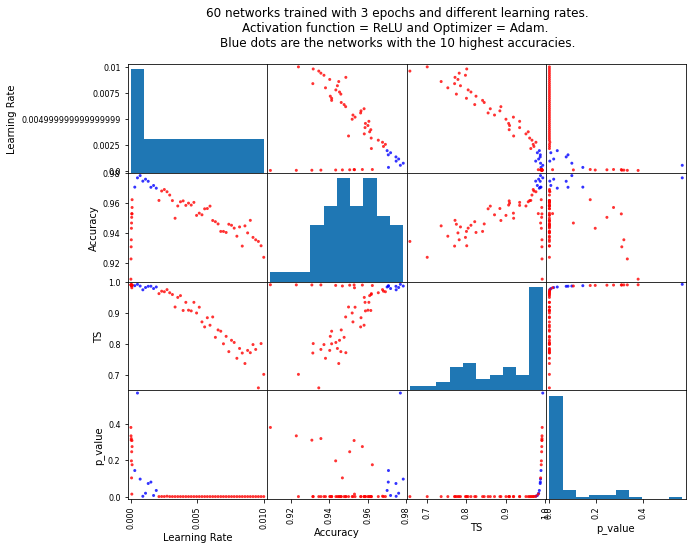

In [ ]:
lrlabels = ["Network Index","Learning Rate","Accuracy","TS","p_value"]
best_performing = 10  
lr_shap_data = pd.read_csv(f'NetworkProject/Notebook2Data/NodeStrengthAnalysis/learning_rate_relu_adam_data.csv',sep=";",names=lrlabels).drop(columns=["Network Index"])
#plots the data. the part after "c=" just finds the 10 highest accuracies and plots a dot as blue if has higher accuracy then the 10th highest accuracy
fdsa = pd.plotting.scatter_matrix(lr_shap_data, alpha=0.8,figsize=(10,8),c=['b' if e > np.min(lr_shap_data["Accuracy"][np.argpartition(lr_shap_data["Accuracy"], -best_performing)[-best_performing:]]) else 'r' for e in lr_shap_data["Accuracy"]])
plt.suptitle(f"{int(lr_shap_data.size/4)} networks trained with 3 epochs and different learning rates.\nActivation function = ReLU and Optimizer = Adam. \nBlue dots are the networks with the {best_performing} highest accuracies.")
#plt.savefig(f"NetworkProject/relu_adam/learning_rate_matrix_plot_relu_adam")
plt.show()